## A Critical Look at Cuckoo Search

This lab explores the common issue of seemingly new optimization algorithms that may not offer genuinely novel ideas. We'll first examine the original Cuckoo Search paper and then critically analyze it using the paper "An analysis of why cuckoo search does not bring any novel ideas to optimization." This exercise builds on our previous discussions of evolutionary algorithms like Differential Evolution and the pitfalls of poor research in fields like Neuroevolution, focusing here on the problem of redundant concepts in optimization.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PathCollection
from typing import Callable
from dataclasses import dataclass
from math import gamma
from IPython.display import Image

### Optimization Problems

This cell defines three common benchmark functions, Sphere, Rosenbrock, and Rastrigin, used to test optimization algorithms. We also used these functions earlier to evaluate Adam, Momentum, and CMA-ES.

In [2]:
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x**2))


def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

BOUNDS = [(-5, 5), (-5, 5)]

### Visualizing Search Dynamics

In [3]:
def animate_cs(
    func: Callable[[np.ndarray], float],
    history: list[np.ndarray],
    bounds: list[tuple[float, float]] = BOUNDS,
    frames: int | None = None,
    filename: str = "cs_animation.gif",
) -> None:
    """
    Creates and saves a GIF showing how the CS population moves over generations.
    """
    if frames is None:
        frames = len(history)

    assert len(bounds) == 2, "This function only supports 2D visualization (expected 2 bounds)."
    x_bounds = (bounds[0][0], bounds[0][1])
    y_bounds = (bounds[1][0], bounds[1][1])

    x = np.linspace(x_bounds[0], x_bounds[1], 200)
    y = np.linspace(y_bounds[0], y_bounds[1], 200)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.array([func(pt) for pt in coords]).reshape(X.shape)

    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(X, Y, Z, levels=20, cmap="viridis")
    fig.colorbar(contour, ax=ax)
    
    def update(i: int):
        # Remove any existing scatter plots (PathCollection instances)
        for coll in ax.collections:
            if isinstance(coll, PathCollection):
                coll.remove()

        ax.set_title(f"Generation {i}")

        DECAY_CONSTANT = 10

        # Plot all generations up to i, with alpha decreasing for older points
        for j in range(i + 1):
            age = i - j
            alpha = float(np.exp(-age / DECAY_CONSTANT))
            pop_j = history[j]
            ax.scatter(pop_j[:, 0], pop_j[:, 1], s=24, color="red", edgecolors="none", alpha=alpha)

        # Return an empty tuple since we're redrawing everything
        return ()
    
    ax.set_xlim(x_bounds[0], x_bounds[1])
    ax.set_ylim(y_bounds[0], y_bounds[1])
    
    anim = animation.FuncAnimation(
        fig,
        update,
        frames=frames,
        interval=200,
        blit=False,  # must be False since we redraw each frame
    )
    
    writer = animation.PillowWriter(fps=5)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Animation saved to {filename}")

### Exercise 1

Read [Cuckoo Search via Levy Flights](https://arxiv.org/pdf/1003.1594) with particular attention to Sections 2, 3, and 4. The primary focus for this exercise is Figure 1, which outlines the core pseudocode of the algorithm.

Your task is to implement the Cuckoo Search algorithm, using Figure 1 as your main reference. As the pseudocode is relatively high-level and lacks 
implementation details, you are encouraged to adopt a straightforward approach in your implementation.

**Action Item:** Document any ambiguities or unclear aspects you encounter in the algorithm description or pseudocode.

> Note: If you find the implementation too challenging or feel stuck, you may proceed directly to Exercise 2.

In [49]:
@dataclass
class CSResult:
    best_vector: np.ndarray
    best_value: float
    history: list[np.ndarray]  # History of populations for animation


class LevyFlight:
    def __init__(self, beta: float = 1.5):
        self.beta = beta

    def __call__(self, size: int) -> np.ndarray:
        sigma_u = (
            gamma(1 + self.beta)
            * np.sin(np.pi * self.beta / 2)
            / (gamma((1 + self.beta) / 2) * self.beta * 2 ** ((self.beta - 1) / 2))
        ) ** (1 / self.beta)
        sigma_v = 1
        u = np.random.normal(0, sigma_u, size)
        v = np.random.normal(0, sigma_v, size)
        step = u / np.abs(v) ** (1 / self.beta)
        return step


def cuckoo_search(
    func: Callable[[np.ndarray], float],
    bounds: list[tuple[float, float]] = BOUNDS,
    pop_size: int = 50,
    alpha: float = 1.0,
    beta: float = 1.5,
    p: float = 0.25,
    max_gen: int = 100,
) -> CSResult:
    """
    Implements the Cuckoo Search algorithm for global optimization.

    Parameters:
        func: Objective function to minimize. Takes a numpy array and returns a float.
        bounds: list of (min, max) pairs for each dimension.
        pop_size: Number of individuals in the population.
        alpha: Step-size scaling factor controlling the overall scale of the Lévy flights.
        beta: Exponent parameter for the Lévy distribution (typically in (1, 3]) that
            influences the heavy-tailed step-length distribution.
        p: Probability (in [0, 1]) that a host bird discovers an alien egg and abandons
            the corresponding nest—i.e., fraction of worse nests to be replaced each generation.
        max_gen: Maximum number of generations to evolve.
    """
    dimensions = len(bounds)
    lower_bounds = np.array([b[0] for b in bounds])
    upper_bounds = np.array([b[1] for b in bounds])
    
    population = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(pop_size, dimensions))
    levy_flight = LevyFlight(beta)
    
    best_value = float("inf")
    best_vector = None
    pop_history = [population.copy()]

    for generation in range(max_gen):
        cuckoo = np.clip(levy_flight(dimensions), a_min=lower_bounds, a_max=upper_bounds) * alpha + population[np.random.randint(len(population))]
        random_nest_idx = np.random.randint(len(population))
        
        if func(population[random_nest_idx]) > func(cuckoo):
            population[random_nest_idx] = cuckoo
            
        fitness = np.array([func(ind) for ind in population])
        num_delete = int(p * pop_size)
        sorted_indices = np.argsort(fitness)
        if fitness[sorted_indices[0]] < best_value:
            best_value = fitness[sorted_indices[0]]
            best_vector = population[sorted_indices[0]]
            
        population = population[sorted_indices[:-num_delete]]
        
        num_new = pop_size - population.shape[0]
        new_individuals = np.random.uniform(low=lower_bounds, high=upper_bounds, size=(num_new, dimensions))

        population = np.vstack((population, new_individuals))
        pop_history.append(population.copy())
        
    return CSResult(
        best_vector = best_vector,
        best_value = best_value,
        history = pop_history
    )

I have quite a few problems and questions about the pseudocode. Is only one cuckoo hatched from a random nest, or do we use each nest to generate cuckoos? The pseudocode suggests that we have only one cuckoo per generation, but I think that way we don't fully utilize our population. Why do we replace a random nest with the cuckoo’s new position? Why don't we replace nest from which cuckoo started? Writing in two separate bullet points that we discard the worst nests and then that we keep the best ones feels a bit redundant. Additionally, the final step is saving the best solution. I believe we should do that during the removal of the worst nests.

I’ll try to merge my observations with the pseudocode provided in the article so as not to repeat actions unnecessarily, but to still follow the instructions given in the pseudocode, whether I find them sensible or not.

### Test implemented CS

In [51]:
result_sphere = cuckoo_search(sphere, bounds=BOUNDS, pop_size=50)
result_rosenbrock = cuckoo_search(rosenbrock, bounds=BOUNDS, pop_size=50)
result_rastrigin = cuckoo_search(rastrigin, bounds=BOUNDS, pop_size=50)

### Experiments

Run CS on all three problems: Sphere, Rosenbrock and Rastrigin. For each problem:
- Visualize the population dynamics over time to illustrate how the search space is explored and exploited.

In [52]:
animate_cs(sphere, result_sphere.history, filename="cs_sphere_animation.gif")

Animation saved to cs_sphere_animation.gif


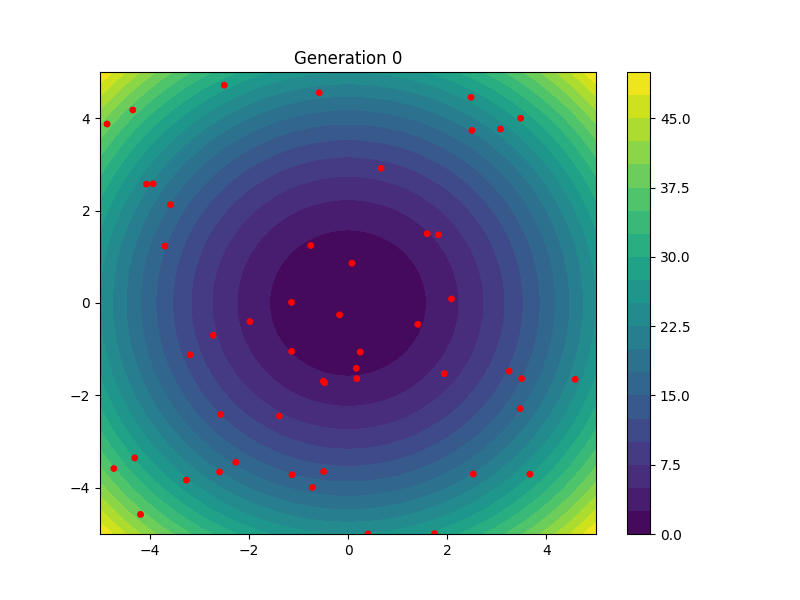

In [54]:
Image(filename="cs_sphere_animation.gif")

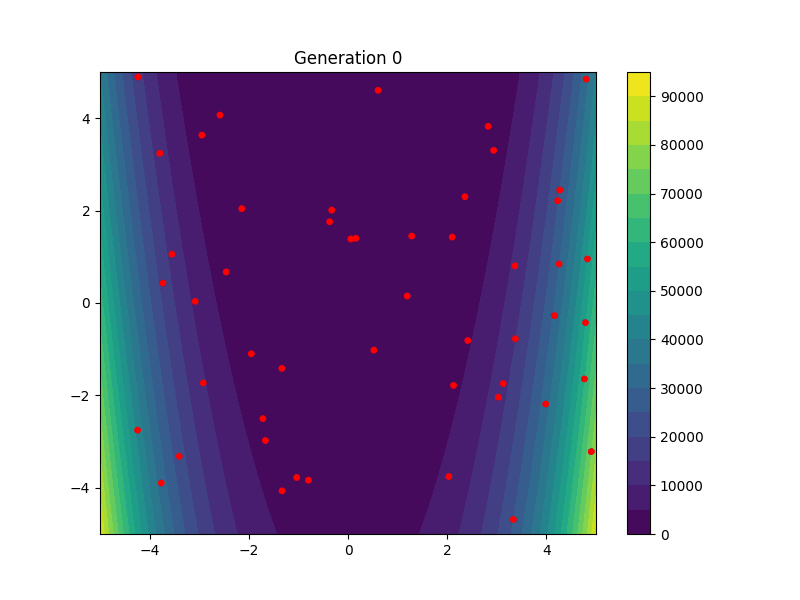

In [56]:
animate_cs(rosenbrock, result_rosenbrock.history, filename="cs_rosenbrock_animation.gif")
Image(filename="cs_rosenbrock_animation.gif")

Animation saved to cs_rastrigin_animation.gif


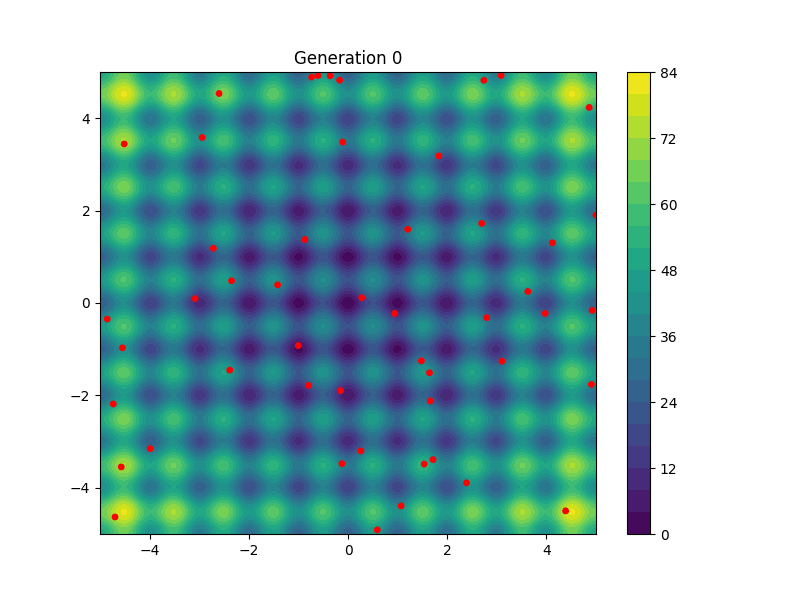

In [57]:
animate_cs(rastrigin, result_rastrigin.history, filename="cs_rastrigin_animation.gif")
Image(filename="cs_rastrigin_animation.gif")

Cuckoo search is able to find better solution with each iteration, but it converges slowly 

### Exercise 2

Read [An analysis of why cuckoo search does not bring any novel ideas to optimization](https://www.sciencedirect.com/science/article/pii/S0305054822000442). Focus particularly on Sections 2 and 3. Section 2.3 provides a detailed description of the implemented Cuckoo Search algorithm. Carefully analyze and compare it with your own, highlighting any differences in assumptions, parameter settings, or algorithmic structure.

The algorithm from this article is described much more clearly. \
We perform evaluation of the initial population. \
Each nest in the population is mutated (this answers my earlier question). \
We select only the top pop_size individuals from the combined original and mutated population. \
A recombination step is added. \
We evaluate the quality of the nests after recombination and save this as the new population.

We need to count the number of algorithm executions differently. Since in each loop iteration we perform multiple mutations, I would suggest adding a maximum number of evaluations of the objective function instead of a maximum number of generations → while max_evals < iterations * pop_size.

### Exercise 3

Read the Introduction of “An analysis of why cuckoo search does not bring any novel ideas to optimization.” Identify and outline three criteria proposed by the authors for evaluating the underlying metaphor of the algorithm. Critically reflect on these criteria, do you find them appropriate and sufficient? Can you suggest any additional criteria or alternative perspectives that might enrich the evaluation?

Those 3 criteria are:
- usefulness
- novelty
- sound motivation

I believe that novelty is not as important as the authors claim. If an algorithm already exists but we come up with a new, clever metaphor that genuinely explains how it works, that’s an important aspect — it can help some people understand or even remember the algorithm. In my opinion, usefulness and sound motivation are much more important. We shouldn’t name an algorithm that performs worse than random search, and we shouldn’t give an algorithm a name that has nothing to do with how it actually works. What’s the point of an algorithm called Backflipping Cat if its behavior has nothing to do with a cat doing a backflip?

### Exercise 4

Read Section 4 of “An analysis of why cuckoo search does not bring any novel ideas to optimization.” Explain the main criticisms they raise against the Cuckoo Search algorithm. What fundamental issues do they identify, and how do these undermine the algorithm's novelty?

The cuckoo algorithm is essentially a variant of the (𝜇 + 𝜆)–ES algorithm. Nothing new is proposed in this algorithm. It doesn't implement any interesting method. What's worse, the reference to the cuckoo is very forced and doesn't help in understanding the algorithm. I believe it was named this way just to have a catchy title and make it easier for the paper to stand out among other metaheuristic articles.

### Exercise 5

Analyze Figures 5 and 8 from [Large-scale Benchmarking of Metaphor-based Optimization Heuristics](https://arxiv.org/pdf/2402.09800). In these figures, Cuckoo Search is denoted as CS. Evaluate its performance relative to the CMA-ES variant (bipop) and Differential Evolution (DE). How does CS compare to these well-established algorithms in terms of optimization performance? Furthermore, critically consider whether performance alone is a sufficient criterion for evaluating optimization algorithms. What other factors should be taken into account?

According to Figure 5:
The cuckoo algorithm is in second place. It lost by only 3 points to the DE algorithm. The CMA-ES BIPOP algorithm is in fourth place. I didn’t expect the cuckoo algorithm to perform so well.

According to Figure 8:
AOCC -> normalized area over the convergence curve (the higher, the better, max = 1).
The leading algorithms are BIPOP and cuckoo - they have the highest average AOCC. However, the cuckoo algorithm has a much greater nearest distance from the baseline, while BIPOP has virtually zero in this regard. This indicates that the cuckoo algorithm finds different, but still good, solutions. The DE algorithm has a slightly higher distance from the baseline than the cuckoo algorithm, but noticeably lower AOCC. According to Figure 8, the cuckoo algorithm is the winner.

I believe that performance is the most important factor when evaluating algorithms. One should also consider how much performance degrades as dimensionality increases, and how many evaluations the algorithm needs to achieve a good result (sometimes we have a limited budget, and then it pays to choose a different algorithm). For beginner programmers, sensitivity to hyperparameter tuning is also important - algorithms that are less sensitive can be more useful to them.

